<a href="https://colab.research.google.com/github/GustavBoye/DRED_Autoencoder/blob/main/SingularPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  44 of 44 completed
[*********************100%***********************]  44 of 44 completed


Epoch 1/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - loss: 0.1227 - val_loss: 0.0116 - learning_rate: 0.0022
Epoch 2/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.0087 - val_loss: 0.0029 - learning_rate: 0.0022
Epoch 3/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0023 - val_loss: 0.0010 - learning_rate: 0.0022
Epoch 4/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 9.8588e-04 - val_loss: 7.6779e-04 - learning_rate: 0.0022
Epoch 5/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 7.8236e-04 - val_loss: 8.1438e-04 - learning_rate: 0.0022
Epoch 6/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 7.8726e-04 - val_loss: 7.8186e-04 - learning_rate: 0.0022
Epoch 7/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 7.8539e-04 - val_loss: 7.9293e-04 - learning_rate: 0.0022
Epoch 8/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 8.0742e-04 - val_loss: 7.8043e-04 - learning_rate: 0.0022
Epoch 9/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - loss: 8.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


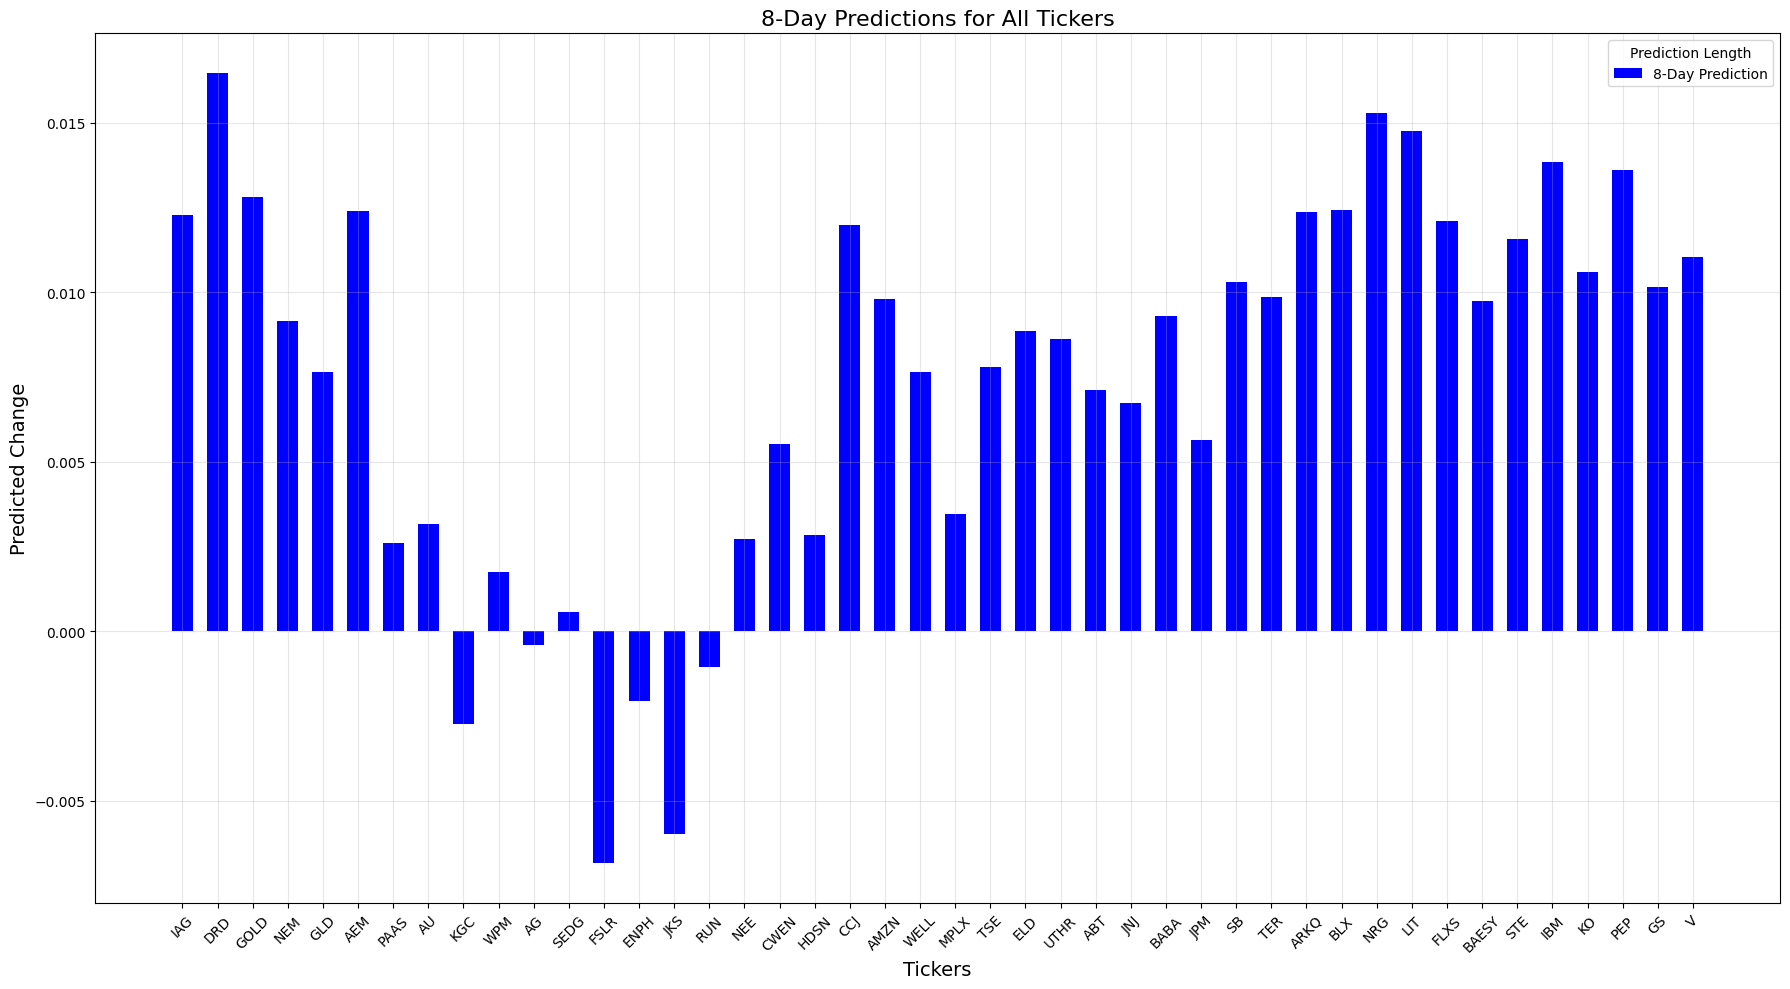

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random

DAYS = 8
HISTORY = 16

# Helper function for normalization
def normalize_min_max(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define input tickers
input_tickers = [
    'IAG', 'DRD', 'GOLD', 'NEM', 'GLD', 'AEM', 'PAAS', 'AU', 'KGC', 'WPM', 'AG',
    'SEDG', 'FSLR', 'ENPH', 'JKS', 'RUN', 'NEE', 'CWEN',
    'HDSN', 'CCJ', 'AMZN', 'WELL', 'MPLX', 'TSE', 'ELD', 'UTHR', 'ABT', 'JNJ', 'BABA', 'JPM', 'SB', 'TER', 'ARKQ', 'BLX', 'NRG', 'LIT', 'FLXS', 'BAESY', 'STE', 'IBM', 'KO', 'PEP', 'GS', 'V'
]

# Fetch stock data
data = yf.download(input_tickers, start="2017-01-01", end="2025-02-09", interval="1d")['Close']
data_volume = yf.download(input_tickers, start="2017-01-01", end="2025-02-09", interval="1d")['Volume']

# Preprocess the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

scaler_vol = MinMaxScaler()
data_scaled_vol = scaler_vol.fit_transform(data_volume)

# Function to create dataset for all stocks
def create_dataset(data, vol, time_steps=HISTORY, future_steps=DAYS):
    X, y = [], []
    num_stocks = data.shape[1]

    for stock_index in range(num_stocks):
        for i in range(len(data) - time_steps - future_steps):
            price_data = normalize_min_max(data[i:i + time_steps])
            vol_data = normalize_min_max(vol[i:i + time_steps])

            # One-hot encode stock index
            stock_identity = np.zeros((time_steps, num_stocks))
            stock_identity[:, stock_index] = 1

            # Combine price, volume, and stock identity
            data_combined = np.concatenate([price_data, vol_data, stock_identity], axis=1)
            X.append(data_combined)

            # Compute target
            future_prices = data[i + time_steps:i + time_steps + future_steps]
            current_price = data[i + time_steps - 1]
            future_avg_price = np.mean(future_prices, axis=0)
            target = future_avg_price - current_price
            y.append(target[stock_index])

    return np.array(X), np.array(y)

# Build the model
def build_unified_model(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv1D(32, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.0006))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)

    x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding="same")(x)
    x1 = tf.keras.layers.Activation('gelu')(x1)
    x = x + x1  # Residual connection

    x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=32)(x, x)  # Transformer attention
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(128, 5, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)

    dense1 = tf.keras.layers.Dense(128, activation='gelu')(x)
    dense2 = tf.keras.layers.Dense(128, activation='gelu')(dense1)
    dense = dense1 + dense2
    dense = tf.keras.layers.Dropout(0.2)(dense)

    dense1b = tf.keras.layers.Dense(128, activation='gelu')(dense)
    dense2b = tf.keras.layers.Dense(128, activation='gelu')(dense1b)
    denseb = dense1 + dense2

    output = tf.keras.layers.Dense(1)(denseb)  # One output for all stocks

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

# Prepare dataset
X, y = create_dataset(data_scaled, data_scaled_vol)

# Split data into training and validation sets
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Build and compile the model
model = build_unified_model(X.shape[1:])
optimizer = tf.keras.optimizers.Adam(learning_rate=random.uniform(0.0005, 0.0025))
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training setup
early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-4, restore_best_weights=True, mode='min', verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1)

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, lr_scheduler])

# Save the model to avoid retraining from scratch
model.save("stock_prediction_model.h5")

# Predict for the last available data point
predictions = model.predict(X[-len(input_tickers):])

# Convert predictions to a dictionary
predictions_dict = {ticker: pred[0] for ticker, pred in zip(input_tickers, predictions)}

# Plot predictions
fig, ax = plt.subplots(figsize=(18, 10))
tickers_range = np.arange(len(input_tickers))
pred_days = np.array([predictions_dict[ticker] for ticker in input_tickers]).flatten()
ax.bar(tickers_range, pred_days, color='blue', width=0.6, label=f'{DAYS}-Day Prediction')

ax.set_title(f"{DAYS}-Day Predictions for All Tickers", fontsize=16)
ax.set_xlabel("Tickers", fontsize=14)
ax.set_ylabel("Predicted Change", fontsize=14)
ax.set_xticks(tickers_range)
ax.set_xticklabels(input_tickers, rotation=45, fontsize=10)
ax.legend(title="Prediction Length", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save predictions as CSV
predictions_df = pd.DataFrame.from_dict(predictions_dict, orient='index', columns=[f'{DAYS}-Day Prediction'])
predictions_df.to_csv(f"predictions_{DAYS}.csv")

from google.colab import files
files.download(f"predictions_{DAYS}.csv")
